In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



1. Setup and Data Loading
First, let's import all necessary libraries and load our data.

In [7]:
def load_and_prepare_data():
    train_data = pd.read_csv('dataset/network_traffic_training.csv')
    test_data = pd.read_csv('dataset/network_traffic_test.csv')
    
    # Convert timestamp to datetime
    train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
    test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
    
    return train_data, test_data

In [8]:
train_data, test_data = load_and_prepare_data()

In [9]:
# Display first few rows and basic information
print("Training Data Shape:", train_data.shape)
print("\nFirst few rows of training data:")
display(train_data.head())
print("\nData Info:")
display(train_data.info())

Training Data Shape: (11000, 10)

First few rows of training data:


,timestamp,source_ip,dest_ip,protocol,port,bytes,packets,duration,is_attack,attack_type
0,2024-12-31 21:12:25.929100,192.168.22.239,10.0.67.64,TCP,175,950.085110,63,6.241030,0,NaN
1,2024-12-31 21:41:44.929326,192.168.127.171,10.0.135.80,TCP,6860,977.375457,71,12.930779,0,NaN
2,2025-01-01 12:40:35.929414,192.168.18.155,10.0.126.245,TCP,55336,1601.676522,44,2.902673,0,NaN
3,2025-01-01 06:53:54.929491,192.168.205.198,10.0.123.239,TCP,26523,1663.007350,33,16.924015,0,NaN
4,2025-01-01 10:24:38.929562,192.168.52.229,10.0.218.18,TCP,59845,1223.459697,29,10.886844,0,NaN



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    11000 non-null  datetime64[ns]
 1   source_ip    11000 non-null  object        
 2   dest_ip      11000 non-null  object        
 3   protocol     11000 non-null  object        
 4   port         11000 non-null  int64         
 5   bytes        11000 non-null  float64       
 6   packets      11000 non-null  int64         
 7   duration     11000 non-null  float64       
 8   is_attack    11000 non-null  int64         
 9   attack_type  1000 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 859.5+ KB


None

2. Exploratory Data Analysis
Let's analyze our data before preprocessing.

Basic Statistics:


,timestamp,port,bytes,packets,duration,is_attack
count,11000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,2025-01-01 02:47:36.306644736,32526.697727,1821.290138,68.654818,27.628244,0.090909
min,2024-12-31 14:43:59.255773,1.000000,-468.940199,1.000000,0.000054,0.000000
25%,2024-12-31 20:45:26.043648,16114.000000,1095.203368,23.750000,6.106965,0.000000
50%,2025-01-01 02:47:18.804915456,32449.000000,1471.908430,49.000000,18.050666,0.000000
75%,2025-01-01 08:46:32.466213632,48741.250000,1841.258517,76.000000,39.272939,0.000000
max,2025-01-01 14:43:45.995598,65521.000000,18075.109953,999.000000,313.299452,1.000000
std,NaN,18846.319441,2376.191984,123.174426,29.748054,0.287493


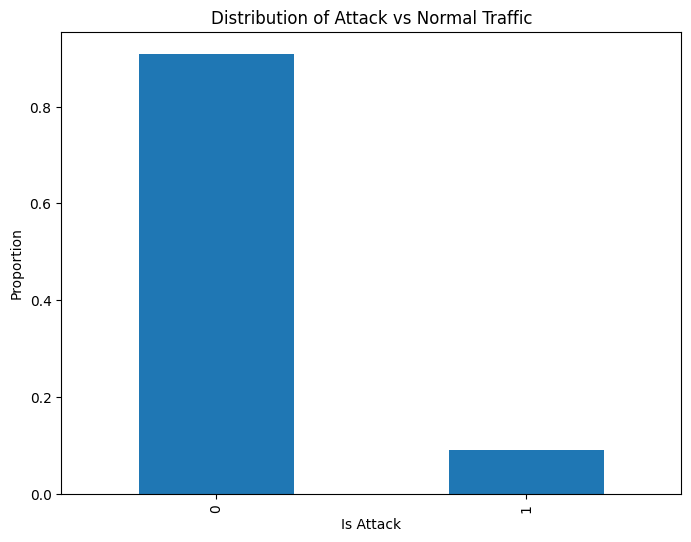

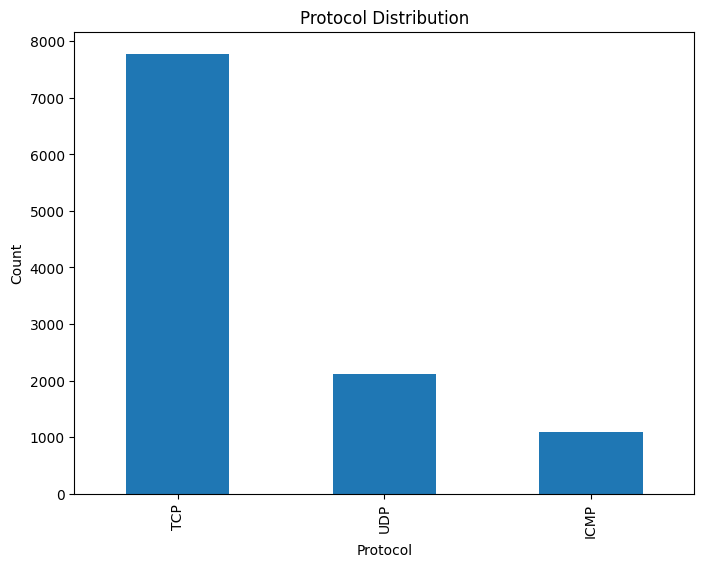

In [10]:
# Basic statistics of numerical columns
print("Basic Statistics:")
display(train_data.describe())

# Distribution of attack vs normal traffic
plt.figure(figsize=(8, 6))
train_data['is_attack'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Attack vs Normal Traffic')
plt.xlabel('Is Attack')
plt.ylabel('Proportion')
plt.show()

# Protocol distribution
plt.figure(figsize=(8, 6))
train_data['protocol'].value_counts().plot(kind='bar')
plt.title('Protocol Distribution')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.show()

3. Feature Engineering
Now let's create additional features for our model.

In [11]:
def engineer_features(df):
    # Create a copy to avoid modifying original data
    df = df.copy()
    
    # Create time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Create network-based features
    df['bytes_per_packet'] = df['bytes'] / df['packets']
    df['packet_rate'] = df['packets'] / df['duration']
    
    # Handle infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    
    # Encode categorical variables
    le = LabelEncoder()
    df['protocol_encoded'] = le.fit_transform(df['protocol'])
    
    # Extract IP features
    df['source_ip_first_octet'] = df['source_ip'].apply(lambda x: int(x.split('.')[0]))
    df['dest_ip_first_octet'] = df['dest_ip'].apply(lambda x: int(x.split('.')[0]))
    
    return df

# Apply feature engineering
train_data_processed = engineer_features(train_data)
test_data_processed = engineer_features(test_data)

# Display new features
print("New features added. Updated columns:")
display(train_data_processed.columns)

New features added. Updated columns:


Index(['timestamp', 'source_ip', 'dest_ip', 'protocol', 'port', 'bytes',
       'packets', 'duration', 'is_attack', 'attack_type', 'hour',
       'day_of_week', 'bytes_per_packet', 'packet_rate', 'protocol_encoded',
       'source_ip_first_octet', 'dest_ip_first_octet'],
      dtype='object')

4. Feature Selection and Preparation
Let's prepare our features for modeling.

In [12]:
def prepare_features(df):
    feature_columns = [
        'bytes', 'packets', 'duration', 'bytes_per_packet', 'packet_rate',
        'protocol_encoded', 'port', 'hour', 'day_of_week',
        'source_ip_first_octet', 'dest_ip_first_octet'
    ]
    
    X = df[feature_columns]
    y = df['is_attack']
    
    return X, y

# Prepare features
X_train, y_train = prepare_features(train_data_processed)
X_test, y_test = prepare_features(test_data_processed)

print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)

Training features shape: (11000, 11)
Testing features shape: (1100, 11)


5. Model Training and Evaluation
Now let's train our model and evaluate its performance.

In [13]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    return model, y_pred, y_pred_prob, X_train_scaled, X_test_scaled

# Train and evaluate
model, y_pred, y_pred_prob, X_train_scaled, X_test_scaled = train_and_evaluate_model(
    X_train, X_test, y_train, y_test
)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00       100

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100



6. Visualization of Results
Let's visualize our model's performance.

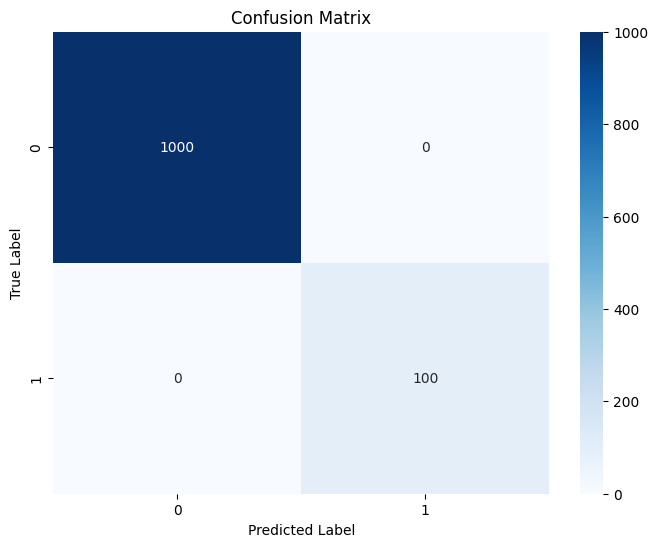

In [14]:
# Confusion Matrix
def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

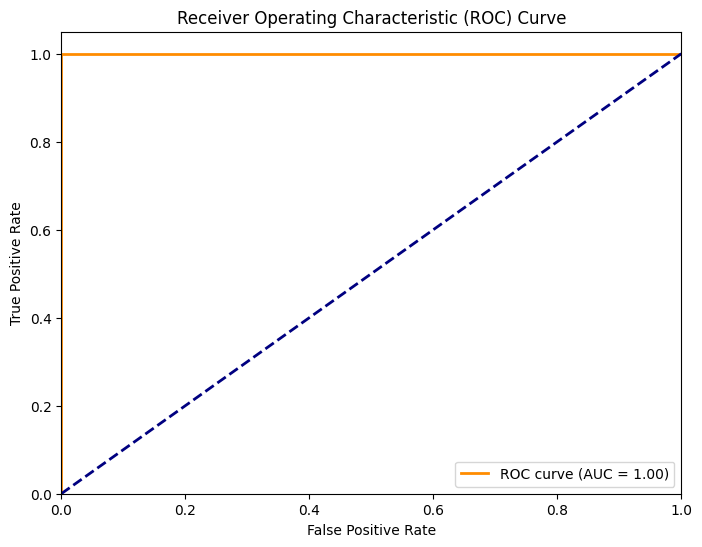

In [15]:
# ROC Curve
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_test, y_pred_prob)

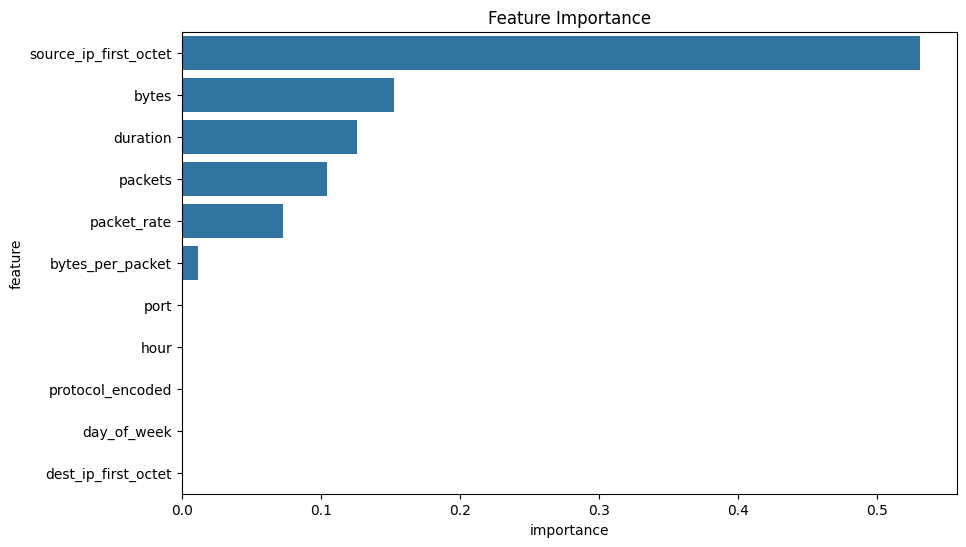

In [16]:
# Feature Importance
def plot_feature_importance(model, feature_columns):
    importances = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances)
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, X_train.columns)

In [ ]:
import joblib

# Save the model and scaler
joblib.dump(model, 'threat_detection_model.joblib')
# joblib.dump(scaler, 'feature_scaler.joblib')

print("Model and scaler saved successfully!")

In [ ]:
def predict_new_traffic(model, scaler, new_data):
    # Preprocess new data
    processed_data = engineer_features(new_data)
    X_new, _ = prepare_features(processed_data)
    
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Make predictions
    predictions = model.predict(X_new_scaled)
    probabilities = model.predict_proba(X_new_scaled)[:, 1]
    
    return predictions, probabilities

# Example usage:
predictions, probabilities = predict_new_traffic(model, scaler, new_traffic_data)